# PYSLICE

### The beginning sections are deisgned to familiarize the user with the many parts of the calculator.
### The final section demonstrates the actual usage of the calculator

## Load The MD Trajectory

In [1]:
import sys,os
sys.path.insert(1,"../../")
from src.io.loader import TrajectoryLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dump = "hBN_truncated.lammpstrj"
dt = 0.005
types = {1:"B", 2:"N"}
a, b = 2.4907733333333337, 2.1570729817355123
trajectory = TrajectoryLoader(dump, timestep = dt, element_names = types).load()

## Generate The Potential

In [3]:
from src.multislice.potentials import gridFromTrajectory,Potential

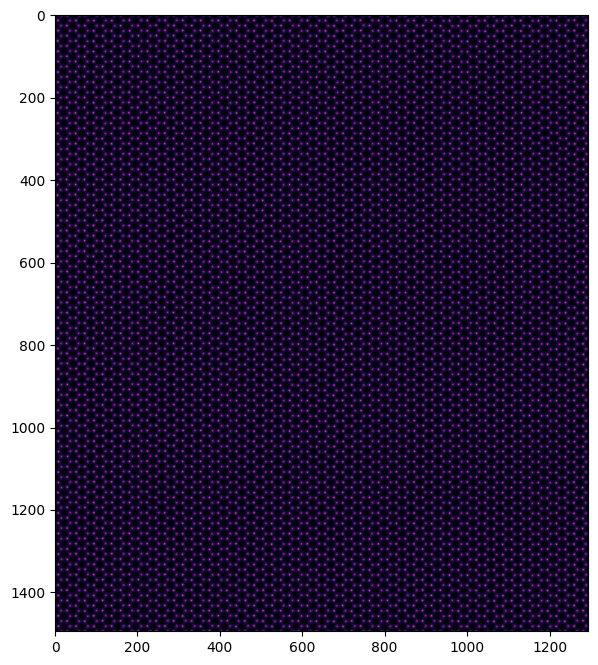

In [4]:
# Assign Variables
positions = trajectory.positions[0]
atom_types = trajectory.atom_types

xs, ys, zs, lx, ly, lz = gridFromTrajectory(trajectory, sampling=0.1, slice_thickness=0.5)

potential = Potential(xs, ys, zs, positions, atom_types, kind="kirkland")

# Extract array data
if hasattr(potential, 'to_cpu'):
        ary = potential.to_cpu()
else:
        ary = np.asarray(potential.array)

# Plot    
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(np.sum(ary,axis=2), cmap="inferno")
plt.show()

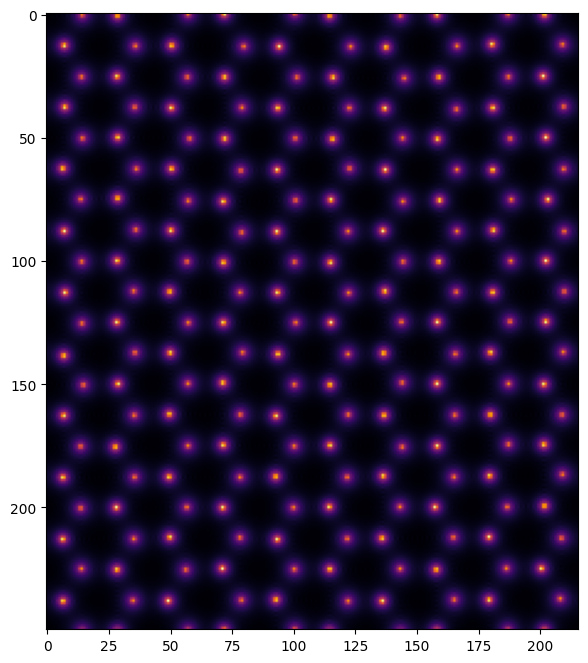

In [5]:
# Lets Make This A Bit Smaller 
trajectory=trajectory.slice_positions([0,10*a],[0,10*b])
xs, ys, zs, lx, ly, lz = gridFromTrajectory(trajectory, sampling=0.1, slice_thickness=0.5)

positions = trajectory.positions[0]
atom_types = trajectory.atom_types
potential = Potential(xs, ys, zs, positions, atom_types, kind="kirkland")

if hasattr(potential, 'to_cpu'):
        ary = potential.to_cpu()
else:
        ary = np.asarray(potential.array)
    
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(np.sum(ary,axis=2), cmap="inferno")
plt.show()

## Generate The Probe

In [6]:
from src.multislice.multislice import Probe,Propagate
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

In [ ]:
def plot_probe(mrad):
    """
    Function to plot probe with given mrad value
    """
    # Create the probe
    probe_interactive = Probe(xs, ys, mrad=mrad, eV=100e3)
    
    # Extract array data
    if hasattr(probe_interactive, 'to_cpu'):
        ary = probe_interactive.to_cpu()
    else:
        ary = np.asarray(probe_interactive.array)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(np.absolute(ary)**.25, cmap="inferno")
    ax.set_title(f"Probe Array (mrad = {mrad})")
    plt.colorbar(im, ax=ax, label="Intensity^0.25")
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(plot_probe, mrad=FloatSlider(value=5.0, min=0, max=30.0, step=0.1, description='mrad:', continuous_update=True))

interactive(children=(FloatSlider(value=5.0, description='mrad:', max=30.0), Output()), _dom_classes=('widget-…

<function __main__.plot_probe(mrad)>

## Propagate

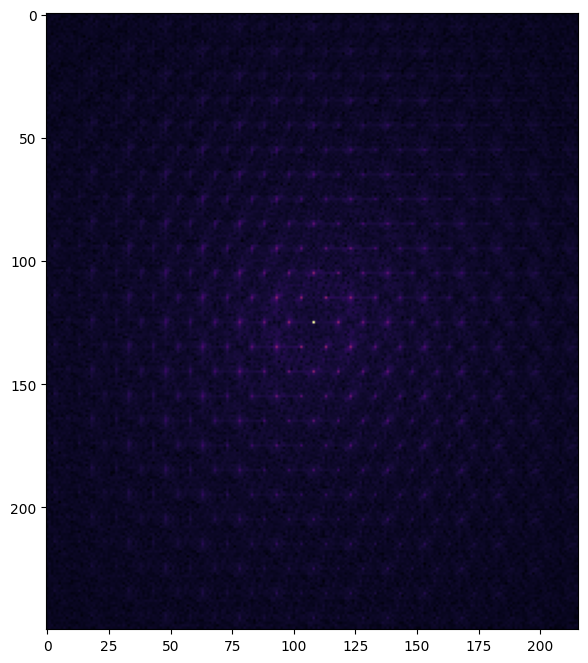

In [8]:
# Quickly Redefining for Clarity
probe = Probe(xs, ys, mrad=0, eV=100e3)
potential = Potential(xs, ys, zs, positions, atom_types, kind="kirkland")

result = Propagate(probe,potential)

if hasattr(result, 'cpu'):
    ary = result.cpu().numpy()  # Convert PyTorch tensor to numpy
else:
    ary = np.asarray(result)  # Already numpy array

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(np.absolute(np.fft.fftshift(np.fft.fft2(ary)))**.25, cmap="inferno")
plt.show()

## Multiple Probes / Scans

In [9]:
from src.multislice.multislice import create_batched_probes
from ipywidgets import IntSlider

In [10]:
# Set Your Base Probe
probe = Probe(xs,ys,mrad=30,eV=100e3)

# Set Your Probe Positions - simple centered grid
x,y = np.meshgrid(
    np.linspace(-2*a, 2*a, 50),  # Centered at 0, spans 10*a
    np.linspace(-2*b, 2*b, 50)   # Centered at 0, spans 10*b
)
xy = np.reshape([x,y], (2, len(x.flat))).T
probes_many = create_batched_probes(probe, xy)

In [11]:
def interactive_probe_viewer(probes_many, xy):
    """Simple slider to browse through probes by index"""
    n_probes = len(xy)
    
    def plot_probe(probe_index):
        # Extract probe data
        if hasattr(probes_many, 'to_cpu'):
            probe_data = probes_many.to_cpu()[probe_index]
        else:
            probe_data = np.asarray(probes_many[probe_index])
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(np.absolute(probe_data)**.25, cmap="inferno")
        
        # Add title with probe info
        x_pos, y_pos = xy[probe_index]
        ax.set_title(f"Probe {probe_index + 1}/{n_probes}\n"
                    f"Position: (x={x_pos:.3f}, y={y_pos:.3f})")
        
        plt.colorbar(im, ax=ax, label="Intensity^0.25")
        plt.tight_layout()
        plt.show()
    
    # Create interactive widget
    interact(plot_probe, 
             probe_index=IntSlider(value=0, min=0, max=n_probes-1, step=1,
                                 description='Probe Index:', continuous_update=True))

# Use it:
interactive_probe_viewer(probes_many, xy)

interactive(children=(IntSlider(value=0, description='Probe Index:', max=2499), Output()), _dom_classes=('widg…

## Propagate Many

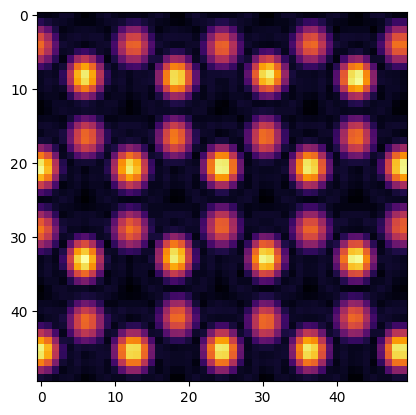

In [12]:
result = Propagate(probes_many,potential)

if hasattr(result, 'cpu'):
    ary = result.cpu().numpy()  # Convert PyTorch tensor to numpy
else:
    ary = np.asarray(result)  # Already numpy array
    
if hasattr(potential.kxs, 'cpu'):
    kxs = potential.kxs.cpu().numpy()
    kys = potential.kys.cpu().numpy()
else:
    kxs = np.asarray(potential.kxs)
    kys = np.asarray(potential.kys)
    
q=np.sqrt(kxs[:,None]**2+kys[None,:]**2)
fig, ax = plt.subplots()
fft=np.fft.fft2(ary,axes=(1,2)) ; fft[:,q<2]=0 # mask in reciprocal space (keep only high scattering angles)

HAADF=np.sum(np.absolute(fft),axis=(1,2)).reshape((len(x),len(y)))
ax.imshow(HAADF, cmap="inferno")
plt.show()

## Calculator Usage

In [18]:
import sys,os
sys.path.insert(1,"../../")

from src.io.loader import TrajectoryLoader
from src.multislice.multislice import probe_grid
from src.multislice.calculators import MultisliceCalculator


from src.postprocessing.haadf_data import HAADFData

import numpy as np
import matplotlib.pyplot as plt

Processing frames: 100%|██████████| 3/3 [00:00<00:00, 12.95frame/s]


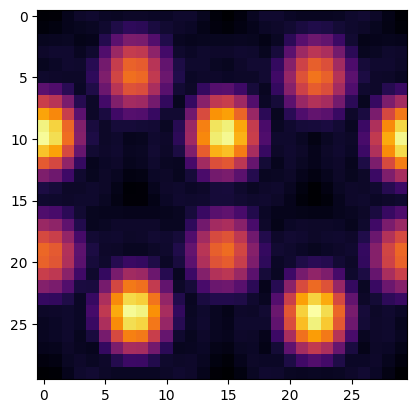

In [19]:
dump="hBN_truncated.lammpstrj"
dt=0.005
types={1:"B",2:"N"}
a,b=2.4907733333333337,2.1570729817355123

# LOAD TRAJECTORY
trajectory=TrajectoryLoader(dump,timestep=dt,element_names=types).load()
trajectory=trajectory.slice_positions([0,10*a],[0,10*b])


slice_timesteps = np.arange(trajectory.n_frames)
np.random.seed(5) ; np.random.shuffle(slice_timesteps)
slice_timesteps = slice_timesteps[:3] # 3 random frames (test we can do multiple but don't bog down the test)


trajectory=trajectory.slice_timesteps( slice_timesteps )


xy=probe_grid([a,3*a],[b,3*b],30,30)

calculator=MultisliceCalculator()
calculator.setup(trajectory,aperture=30,probe_positions=xy,voltage_eV=100e3,sampling=.1,slice_thickness=.5)
exitwaves = calculator.run()

haadf=HAADFData(exitwaves).ADF(preview=False)

fig, ax = plt.subplots()
ax.imshow(haadf.T, cmap="inferno")
plt.show()

## EELS Simulation

In [1]:
import sys,os
sys.path.insert(1,"../../")

from src.io.loader import TrajectoryLoader
from src.multislice.multislice import probe_grid
from src.multislice.calculators_memory_efficient import MultisliceCalculatorMemoryEfficient
from src.postprocessing.tacaw_data_per_probe import TACAWDataPerProbe

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider, FloatSlider

In [2]:
dump="hBN_truncated.lammpstrj"
dt=.005
types={1:"B",2:"N"}
a,b=2.4907733333333337,2.1570729817355123

# LOAD TRAJECTORY
trajectory=TrajectoryLoader(dump,timestep=dt,element_names=types).load()

# TACAW CALCULATION: ALL TIMESTEPS, PARALLEL BEAM
calculator=MultisliceCalculatorMemoryEfficient()
calculator.setup(trajectory,aperture=0,voltage_eV=100e3,sampling=.1,slice_thickness=.5)
tacaw = calculator.run()

#tacaw = TACAWData(exitwaves)

def tacaw_viewer(tacaw):
    n_frequencies = len(tacaw.frequencies)
    frequencies_thz = tacaw.frequencies
    
    def plot_frequency(frequency_index):
        ary = np.asarray(tacaw.intensity[0, frequency_index, :, :] ** 0.25)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(ary.T, cmap="inferno")
        
        # Show actual frequency value in title
        freq_value = frequencies_thz[frequency_index]
        ax.set_title(f"TACAW Intensity - Frequency: {freq_value:.3f} THz\n"
                    f"Index: {frequency_index}/{n_frequencies-1}")
        
        plt.colorbar(im, ax=ax, label="Intensity^0.25")
        plt.tight_layout()
        plt.show()
    
    interact(plot_frequency,
             frequency_index=IntSlider(value=0, min=0, max=n_frequencies-1, step=1,
                                     description='Freq (THz):', continuous_update=True))

# Use it:
tacaw_viewer(tacaw)

Processing frames: 100%|██████████| 100/100 [00:00<00:00, 1127.49frame/s]


interactive(children=(IntSlider(value=0, description='Freq (THz):', max=99), Output()), _dom_classes=('widget-…

Computing average spectrum: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


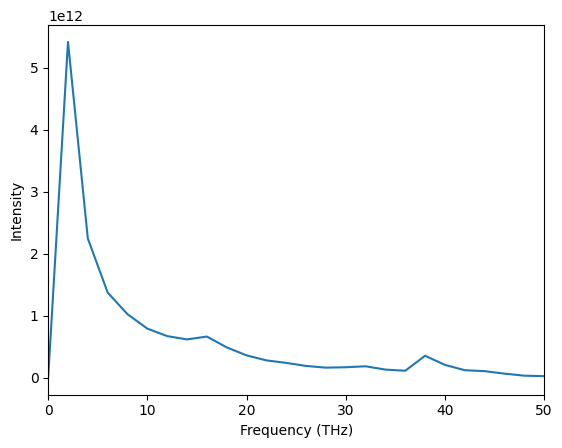

In [3]:
spectrum = tacaw.spectrum(probe_index=None)
freq = tacaw.frequencies

fig, ax = plt.subplots()
ax.plot(freq, spectrum)
ax.set_xlabel('Frequency (THz)')
ax.set_xlim(0,50)
ax.set_ylabel('Intensity')
plt.show()

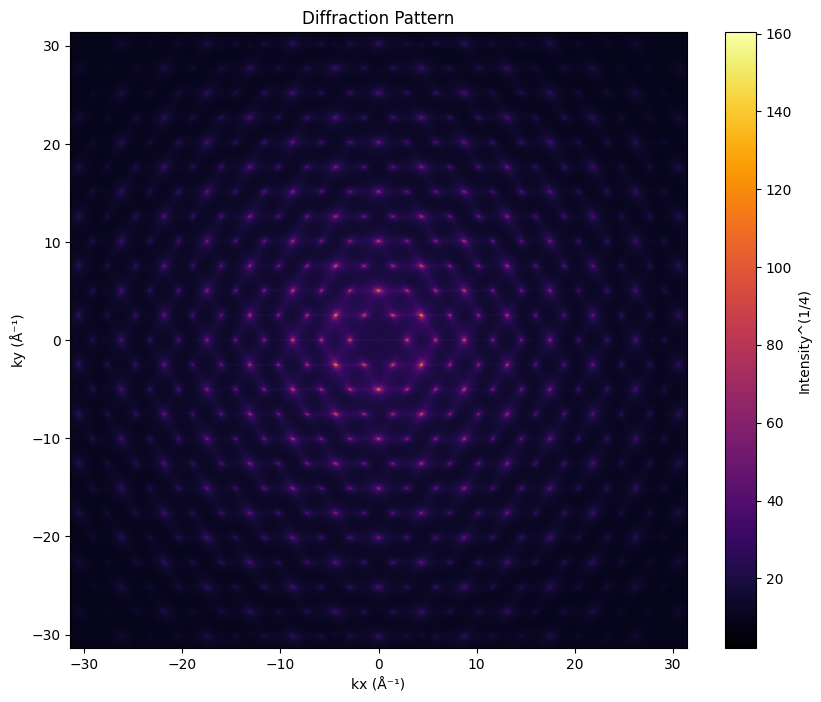

In [4]:
diff = tacaw.diffraction()**0.25
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(diff, cmap="inferno",
          extent=[tacaw.kxs.min(), tacaw.kxs.max(),
tacaw.kys.min(), tacaw.kys.max()], aspect='equal')
ax.set_xlabel('kx (Å⁻¹)')
ax.set_ylabel('ky (Å⁻¹)')
ax.set_title('Diffraction Pattern')
plt.colorbar(ax.get_images()[0], label='Intensity^(1/4)')
plt.show()

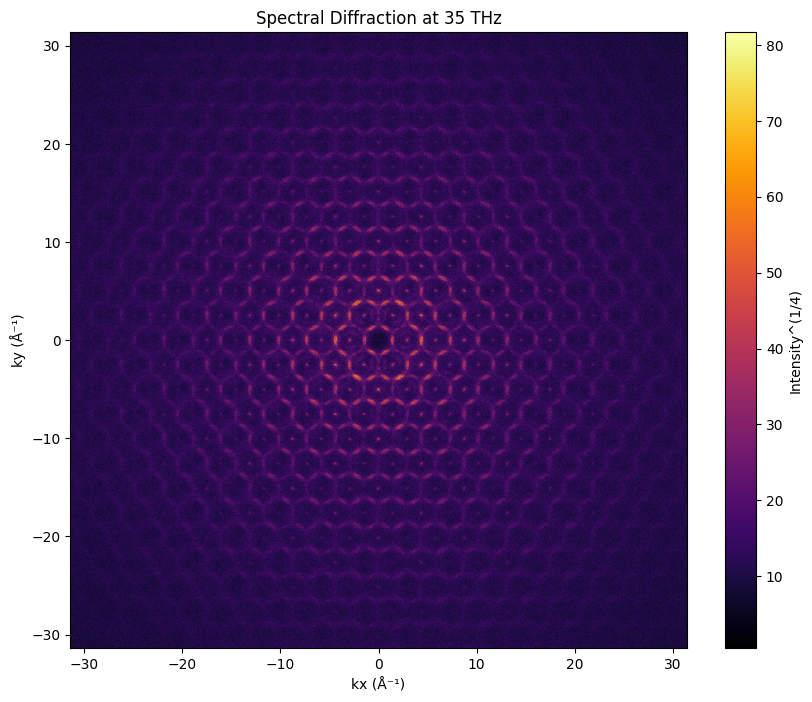

In [5]:
spec_diff = tacaw.spectral_diffraction(frequency=35, probe_index=0)**0.25
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(spec_diff, cmap="inferno",
               extent=[tacaw.kxs.min(), tacaw.kxs.max(),
                      tacaw.kys.min(), tacaw.kys.max()], aspect='equal')
ax.set_xlabel('kx (Å⁻¹)')
ax.set_ylabel('ky (Å⁻¹)')
ax.set_title('Spectral Diffraction at 35 THz')
plt.colorbar(im, label='Intensity^(1/4)')
plt.show()

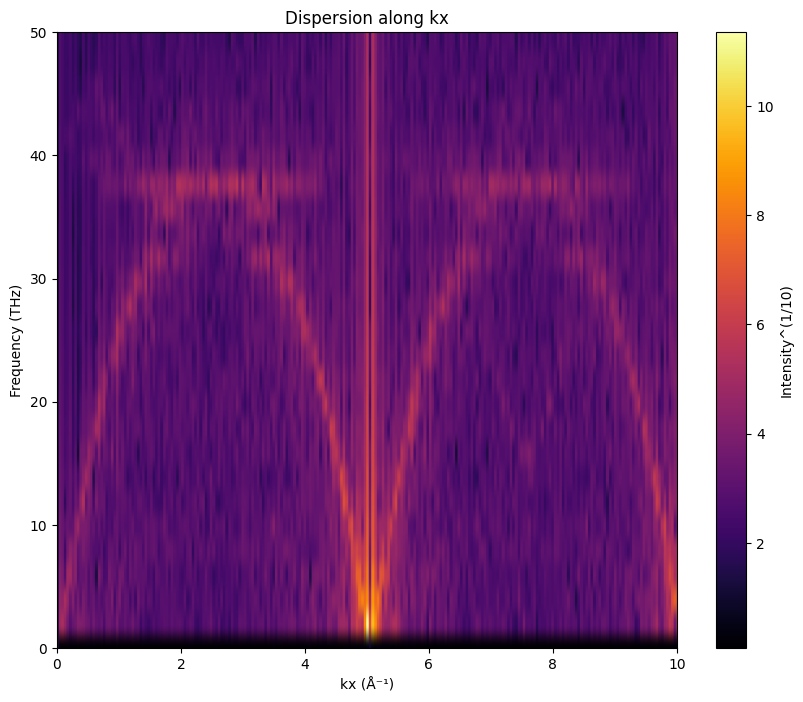

In [5]:
kx = np.linspace(0,10,1000); ky = np.linspace(0,0,1000)
spec_diff = tacaw.dispersion(kx,ky)**0.1
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(spec_diff, cmap="inferno", origin='lower',
               extent=[kx.min(), kx.max(),
tacaw.frequencies.min(), tacaw.frequencies.max()],
               aspect='auto')
ax.set_xlabel('kx (Å⁻¹)')
ax.set_ylabel('Frequency (THz)')
ax.set_ylim(0,50)
ax.set_title('Dispersion along kx')
plt.colorbar(im, label='Intensity^(1/10)')
plt.show()

## Spectrum Image

In [6]:
import sys,os
sys.path.insert(1,"../../")

from src.io.loader import TrajectoryLoader
from src.multislice.multislice import probe_grid


import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider, FloatSlider

In [8]:
dump="hBN_truncated.lammpstrj"
dt=0.005
types={1:"B",2:"N"}
a,b=2.4907733333333337,2.1570729817355123

# LOAD TRAJECTORY
trajectory=TrajectoryLoader(dump,timestep=dt,element_names=types).load()
trajectory=trajectory.slice_positions([0,5*a],[0,5*b])


xy=probe_grid([a,3*a],[b,3*b],30,30)

calculator=MultisliceCalculatorMemoryEfficient()
calculator.setup(trajectory,aperture=30,probe_positions=xy,voltage_eV=100e3,sampling=.1,slice_thickness=.5)
tacaw = calculator.run()

#tacaw=TACAWData(exitwaves)



Processing frames: 100%|██████████| 100/100 [00:36<00:00,  2.76frame/s]


Computing spectrum image at 2.0 THz: 100%|██████████| 9/9 [00:00<00:00, 286.93it/s]


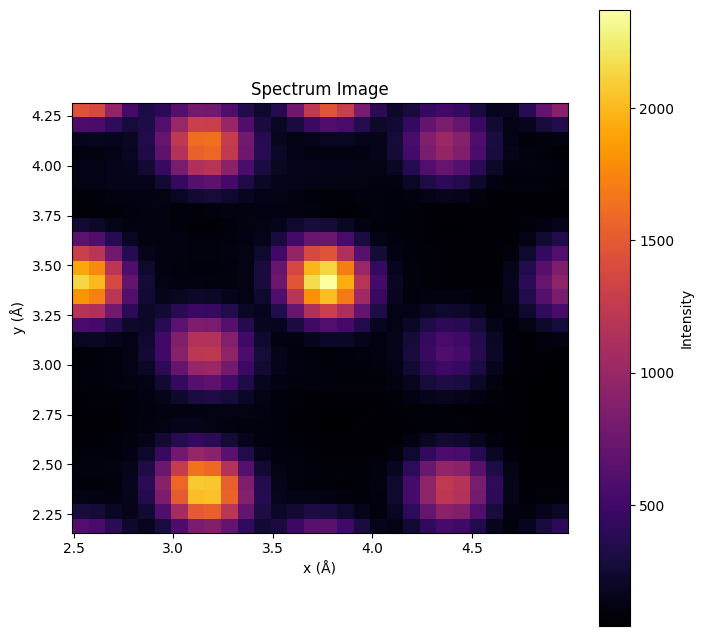

In [11]:
# Get spectrum image at this frequency
spec_img = tacaw.spectrum_image(2)
# Reshape to match your probe grid (30x30)
spec_img_2d = spec_img.reshape(30, 30)
# Plot
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(spec_img_2d, cmap="inferno",
               extent=[a, 2*a, b, 2*b],
               origin='lower', aspect='equal')
ax.set_xlabel('x (Å)')
ax.set_ylabel('y (Å)')
ax.set_title(f'Spectrum Image')
plt.colorbar(im, label='Intensity')
plt.show()

In [12]:
from ipywidgets import interact, IntSlider
def spectrum_image_viewer(tacaw, grid_shape=(30, 30), extent=[a, 2*a, b, 2*b]):
    n_frequencies = len(tacaw.frequencies)
    frequencies_thz = tacaw.frequencies
    def plot_frequency(frequency_index):
        freq_value = frequencies_thz[frequency_index]
        # Get spectrum image at this frequency
        spec_img = tacaw.spectrum_image(freq_value)
        spec_img_2d = spec_img.reshape(grid_shape)
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(spec_img_2d, cmap="inferno",
                       extent=extent,
                       origin='lower', aspect='equal')
        ax.set_xlabel('x (Å)')
        ax.set_ylabel('y (Å)')
        ax.set_title(f"Spectrum Image - Frequency: {freq_value:.3f} THz\n"
                    f"Index: {frequency_index}/{n_frequencies-1}")
        plt.colorbar(im, ax=ax, label="Intensity")
        plt.tight_layout()
        plt.show()
    interact(plot_frequency,
frequency_index=IntSlider(value=n_frequencies//2, min=0,
max=n_frequencies-1, step=1,description='Freq Index:', continuous_update=True))
# Use it:
spectrum_image_viewer(tacaw, grid_shape=(30, 30), extent=[a, 2*a, b, 2*b])

interactive(children=(IntSlider(value=50, description='Freq Index:', max=99), Output()), _dom_classes=('widget…